# Extra 2.1 - Unbalanced Data - Application 1: CollabMap Data Quality

Assessing the quality of crowdsourced data in CollabMap from their provenance

In this notebook, we compared the classification accuracy on **unbalanced** (original) CollabMap datasets vs that on a **balanced** CollabMap datasets.

* **Goal**: To determine if the provenance network analytics method can identify trustworthy data (i.e. buildings, routes, and route sets) contributed by crowd workers in [CollabMap](https://collabmap.org/).
* **Classification labels**: $\mathcal{L} = \left\{ \textit{trusted}, \textit{uncertain} \right\} $.
* **Training data**:
  - Buildings: 5175
  - Routes: 4710
  - Route sets: 4997



## Reading data
The CollabMap dataset is provided in the [`collabmap/depgraphs.csv`](collabmap/depgraphs.csv) file, each row corresponds to a building, route, or route sets created in the application:
* `id`: the identifier of the data entity (i.e. building/route/route set).
* `trust_value`: the beta trust value calculated from the votes for the data entity.
* The remaining columns provide the provenance network metrics calculated from the dependency provenance graph of the entity.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("collabmap/depgraphs.csv", index_col='id')
df.head()

,trust_value,entities,agents,activities,nodes,edges,diameter,assortativity,acc,acc_e,...,mfd_e_a,mfd_e_ag,mfd_a_e,mfd_a_a,mfd_a_ag,mfd_ag_e,mfd_ag_a,mfd_ag_ag,mfd_der,powerlaw_alpha
id,,,,,,,,,,,,,,,,,,,,,
Route41053.0,0.833333,9,0,6,15,26,3,-0.272207,0.891091,0.809409,...,1,0,2,0,0,0,0,0,2,-1.00000
RouteSet9042.1,0.600000,6,0,3,9,15,2,-0.412974,0.879630,0.847222,...,1,0,1,0,0,0,0,0,1,-1.00000
Building19305.0,0.428571,6,0,4,10,13,2,-0.527046,0.901235,0.822222,...,1,0,1,0,0,0,0,0,1,3.19876
Building1136.0,0.428571,6,0,4,10,13,2,-0.527046,0.901235,0.822222,...,1,0,1,0,0,0,0,0,1,3.19876
Building24156.0,0.833333,9,0,5,14,24,3,-0.363937,0.838034,0.757639,...,2,0,2,2,0,0,0,0,2,-1.00000


In [3]:
df.describe()

,trust_value,entities,agents,activities,nodes,edges,diameter,assortativity,acc,acc_e,...,mfd_e_a,mfd_e_ag,mfd_a_e,mfd_a_a,mfd_a_ag,mfd_ag_e,mfd_ag_a,mfd_ag_ag,mfd_der,powerlaw_alpha
count,14882.000000,14882.000000,14882.0,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,...,14882.000000,14882.0,14882.000000,14882.000000,14882.0,14882.0,14882.0,14882.0,14882.000000,14882.000000
mean,0.766706,13.384693,0.0,6.793375,20.178067,39.118868,2.771267,-0.363791,0.806123,0.762426,...,1.545424,0.0,1.742575,0.987166,0.0,0.0,0.0,0.0,1.802782,-0.226061
std,0.115301,17.165677,0.0,7.247706,24.147888,59.648535,0.917298,0.238658,0.203627,0.200090,...,1.044079,0.0,1.012615,1.391763,0.0,0.0,0.0,0.0,0.938974,1.590865
min,0.153846,2.000000,0.0,0.000000,2.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,-1.000000
25%,0.750000,5.000000,0.0,2.000000,7.000000,10.000000,2.000000,-0.500000,0.820309,0.757639,...,1.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,-1.000000
50%,0.800000,9.000000,0.0,5.000000,14.000000,24.000000,3.000000,-0.330835,0.849790,0.809409,...,1.000000,0.0,2.000000,0.000000,0.0,0.0,0.0,0.0,2.000000,-1.000000
75%,0.833333,14.000000,0.0,9.000000,22.000000,40.000000,3.000000,-0.251256,0.880083,0.854159,...,2.000000,0.0,2.000000,2.000000,0.0,0.0,0.0,0.0,2.000000,-1.000000
max,0.965517,178.000000,0.0,70.000000,248.000000,706.000000,13.000000,0.494008,1.000000,1.000000,...,13.000000,0.0,12.000000,13.000000,0.0,0.0,0.0,0.0,12.000000,4.674298


## Labelling data
Based on its trust value, we categorise the data entity into two sets: _trusted_ and _uncertain_. Here, the threshold for the trust value, whose range is [0, 1], is chosen to be 0.75.

In [4]:
trust_threshold = 0.75
df['label'] = df.apply(lambda row: 'Trusted' if row.trust_value >= trust_threshold else 'Uncertain', axis=1)
df.head()  # The new label column is the last column below

,trust_value,entities,agents,activities,nodes,edges,diameter,assortativity,acc,acc_e,...,mfd_e_ag,mfd_a_e,mfd_a_a,mfd_a_ag,mfd_ag_e,mfd_ag_a,mfd_ag_ag,mfd_der,powerlaw_alpha,label
id,,,,,,,,,,,,,,,,,,,,,
Route41053.0,0.833333,9,0,6,15,26,3,-0.272207,0.891091,0.809409,...,0,2,0,0,0,0,0,2,-1.00000,Trusted
RouteSet9042.1,0.600000,6,0,3,9,15,2,-0.412974,0.879630,0.847222,...,0,1,0,0,0,0,0,1,-1.00000,Uncertain
Building19305.0,0.428571,6,0,4,10,13,2,-0.527046,0.901235,0.822222,...,0,1,0,0,0,0,0,1,3.19876,Uncertain
Building1136.0,0.428571,6,0,4,10,13,2,-0.527046,0.901235,0.822222,...,0,1,0,0,0,0,0,1,3.19876,Uncertain
Building24156.0,0.833333,9,0,5,14,24,3,-0.363937,0.838034,0.757639,...,0,2,2,0,0,0,0,2,-1.00000,Trusted


Having used the trust valuue to label all the data entities, we remove the `trust_value` column from the data frame.

In [5]:
# We will not use trust value from now on
df.drop('trust_value', axis=1, inplace=True)
df.shape  # the dataframe now have 23 columns (22 metrics + label)

(14882, 23)

## Filtering data
We split the dataset into three: buildings, routes, and route sets.

In [6]:
df_buildings = df.filter(like="Building", axis=0)
df_routes = df.filter(regex="^Route\d", axis=0)
df_routesets = df.filter(like="RouteSet", axis=0)
df_buildings.shape, df_routes.shape, df_routesets.shape  # The number of data points in each dataset

((5175, 23), (4997, 23), (4710, 23))

# Classification on unbalanced (original) data

We now run the cross validation tests on the three unbalanced datasets (`df_buildings`, `df_routes`, and `df_routesets`) using all the features (`combined`), only the generic network metrics (`generic`), and only the provenance-specific network metrics (`provenance`). Please refer to [Cross Validation Code.ipynb](Cross%20Validation%20Code.ipynb) for the detailed description of the cross validation code.

In [7]:
from analytics import test_classification

### Building Classification

We test the classification of buildings, collect individual accuracy scores `results` and the importance of every feature in each test in `importances` (both are Pandas Dataframes). These two tables will also be used to collect data from testing the classification of routes and route sets later.

In [8]:
# Cross validation test on building classification
res, imps = test_classification(df_buildings)

# adding the Data Type column
res['Data Type'] = 'Building'
imps['Data Type'] = 'Building'

# storing the results and importance of features
results_unb = res
importances_unb = imps

Accuracy: 95.69% ±0.0513 <-- combined
Accuracy: 95.73% ±0.0493 <-- generic
Accuracy: 95.68% ±0.0499 <-- provenance


### Route Classification

In [9]:
# Cross validation test on route classification
res, imps = test_classification(df_routes)

# adding the Data Type column
res['Data Type'] = 'Route'
imps['Data Type'] = 'Route'

# storing the results and importance of features
results_unb = results_unb.append(res, ignore_index=True)
importances_unb = importances_unb.append(imps, ignore_index=True)

Accuracy: 96.00% ±0.0527 <-- combined
Accuracy: 95.84% ±0.0539 <-- generic
Accuracy: 95.33% ±0.0552 <-- provenance


### Route Set Classification

In [10]:
# Cross validation test on route classification
res, imps = test_classification(df_routesets)

# adding the Data Type column
res['Data Type'] = 'Route Set'
imps['Data Type'] = 'Route Set'

# storing the results and importance of features
results_unb = results_unb.append(res, ignore_index=True)
importances_unb = importances_unb.append(imps, ignore_index=True)

Accuracy: 94.84% ±0.0594 <-- combined
Accuracy: 94.34% ±0.0629 <-- generic
Accuracy: 94.42% ±0.0606 <-- provenance


 ## Classification on balanced data
 
 We repeat the same experiements but now with balanced datasets

### Balancing Data
This section explore the balance of each of the three datasets and balance them using the [SMOTE Oversampling Method](https://www.jair.org/media/953/live-953-2037-jair.pdf).

In [11]:
from analytics import balance_smote

#### Buildings

In [12]:
df_buildings.label.value_counts()

Trusted      4491
Uncertain     684
Name: label, dtype: int64

Balancing the building dataset:

In [13]:
df_buildings = balance_smote(df_buildings)

Original data shapes: (5175, 22) (5175,)
Balanced data shapes: (8982, 22) (8982,)


#### Routes

In [14]:
df_routes.label.value_counts()

Trusted      3908
Uncertain    1089
Name: label, dtype: int64

Balancing the route dataset:

In [15]:
df_routes = balance_smote(df_routes)

Original data shapes: (4997, 22) (4997,)
Balanced data shapes: (7816, 22) (7816,)


#### Route Sets

In [16]:
df_routesets.label.value_counts()

Trusted      3019
Uncertain    1691
Name: label, dtype: int64

Balancing the route set dataset:

In [17]:
df_routesets = balance_smote(df_routesets)

Original data shapes: (4710, 22) (4710,)
Balanced data shapes: (6038, 22) (6038,)


### Building Classification

We test the classification of buildings, collect individual accuracy scores `results` and the importance of every feature in each test in `importances` (both are Pandas Dataframes). These two tables will also be used to collect data from testing the classification of routes and route sets later.

In [18]:
# Cross validation test on building classification
res, imps = test_classification(df_buildings)

# adding the Data Type column
res['Data Type'] = 'Building'
imps['Data Type'] = 'Building'

# storing the results and importance of features
results_bal = res
importances_bal = imps

Accuracy: 89.92% ±0.0595 <-- combined
Accuracy: 89.94% ±0.0588 <-- generic
Accuracy: 89.79% ±0.0608 <-- provenance


### Route Classification

In [19]:
# Cross validation test on route classification
res, imps = test_classification(df_routes)

# adding the Data Type column
res['Data Type'] = 'Route'
imps['Data Type'] = 'Route'

# storing the results and importance of features
results_bal = results_bal.append(res, ignore_index=True)
importances_bal = importances_bal.append(imps, ignore_index=True)

Accuracy: 96.74% ±0.0394 <-- combined
Accuracy: 96.57% ±0.0397 <-- generic
Accuracy: 96.09% ±0.0416 <-- provenance


### Route Set Classification

In [20]:
# Cross validation test on route classification
res, imps = test_classification(df_routesets)

# adding the Data Type column
res['Data Type'] = 'Route Set'
imps['Data Type'] = 'Route Set'

# storing the results and importance of features
results_bal = results_bal.append(res, ignore_index=True)
importances_bal = importances_bal.append(imps, ignore_index=True)

Accuracy: 95.74% ±0.0492 <-- combined
Accuracy: 95.23% ±0.0531 <-- generic
Accuracy: 95.36% ±0.0503 <-- provenance


## Combining the results

In [21]:
# Merging the two result sets
results_unb['Balanced'] = False
results_bal['Balanced'] = True
results = results_unb.append(results_bal, ignore_index=True)

## Charting the accuracy scores

In [22]:
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

Converting the accuracy score from [0, 1] to percentage, i.e [0, 100]:

In [23]:
results.Accuracy = results.Accuracy * 100

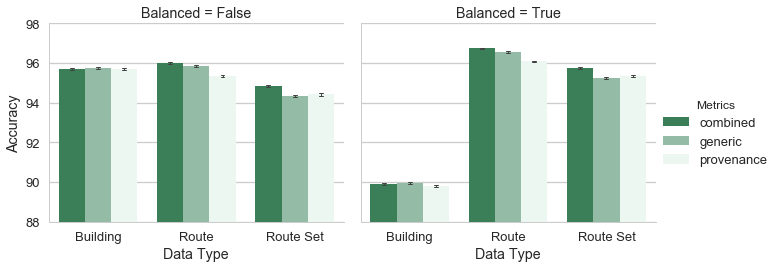

In [24]:
pal = sns.light_palette("seagreen", n_colors=3, reverse=True)
g = sns.factorplot(data=results, x='Data Type', y='Accuracy', hue='Metrics', col='Balanced',
                   kind='bar', palette=pal, aspect=1.2, errwidth=1, capsize=0.04)
g.set(ylim=(88, 98))

For this application, training and testing classifiers on unbalanced data yields similar levels of accuracy, except for buildings. It seems that the heavily skewed `buildings` dataset (87% vs 13%) inflates the performance of the building classifiers, hence the difference. If the classifier always predicts _trusted_, it is already 87% accurace on the unbalanced data (compared to the 50% baseline accuracy on a balance dataset with random predictions).